# BYOD DEVICE

In [77]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
#importing dataset 
dataset=pd.read_csv('url_classification.csv')
dataset.head()

,1,http://www.liquidgeneration.com/,Adult
0,2,http://www.onlineanime.org/,Adult
1,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
2,4,http://www.galeon.com/kmh/,Adult
3,5,http://www.fanworkrecs.com/,Adult
4,6,http://www.animehouse.com/,Adult


## Data PreProcessing

In [89]:
# checking shape of dataset 
dataset.shape

(1562977, 3)

In [91]:
# assigning columns names to dataset
dataset.columns=['sr_no','website_url','category']

In [93]:
dataset.head()

,sr_no,website_url,category
0,2,http://www.onlineanime.org/,Adult
1,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
2,4,http://www.galeon.com/kmh/,Adult
3,5,http://www.fanworkrecs.com/,Adult
4,6,http://www.animehouse.com/,Adult


In [95]:
# removing first column as it contains sr_no
df=dataset.iloc[:,1:]

In [97]:
dataset=dataset.dropna(axis=0)

In [65]:
# dataset.drop(df.index[5555:35325],inplace=True)
# dataset.drop(df.index[35325:282000],inplace=True)
# dataset.drop(df.index[289166:523000],inplace=True)
# dataset.drop(df.index[529343:640000],inplace=True)
# dataset.drop(df.index[647305:698000],inplace=True)
# dataset.drop(df.index[703782:757000],inplace=True)
# dataset.drop(df.index[763879:787000],inplace=True)

ERROR! Session/line number was not unique in database. History logging moved to new session 171


In [99]:
dataset.drop(df.index[792148:820000],inplace=True)
dataset.drop(df.index[838330:840000],inplace=True)

In [101]:
dataset['category'].value_counts()

Arts          253840
Society       243942
Business      240176
Computers     117961
Science       110286
Recreation    106586
Sports        101328
Shopping       95270
Health         60097
Reference      58247
Games          56477
Adult          35324
Home           28269
Kids           18330
News            7319
Name: category, dtype: int64

In [85]:
df.shape

(1535122, 2)

In [83]:
dataset=df[:]

In [31]:
dataset.shape

(1533207, 2)

In [19]:
# check for nan values in dataset
df.isnull().sum()

website_url    3
category       0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562977 entries, 0 to 1562976
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   website_url  1562974 non-null  object
 1   category     1562977 non-null  object
dtypes: object(2)
memory usage: 23.8+ MB


In [23]:
# dropping rows with nan url's  
df=df.dropna(axis=0)

In [31]:
df.isnull().sum()

website_url    0
category       0
dtype: int64

In [43]:
df.shape

(1562974, 2)

In [37]:
df['category'].value_counts()

Arts          253840
Society       243942
Business      240176
Computers     117961
Science       110286
Recreation    106586
Sports        101328
Shopping       95270
Health         60097
Reference      58247
Games          56477
Kids           46182
Adult          35324
Home           28269
News            8989
Name: category, dtype: int64

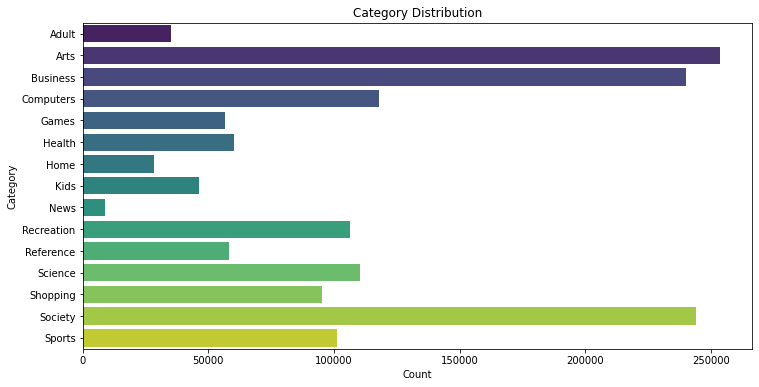

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(y=df['category'],palette='viridis')
plt.title("Category Distribution")
plt.ylabel("Category")
plt.xlabel("Count")
plt.show()

### URLs Processing

In [39]:
# importing regular expresions library for cleaning url's 
import re

def preprocess_url(url):
    """
    takes url's from dataset and preprocess them by removing path,special characters and extracting domain names,path and length of given url.
    Args:
        url (_type_): object
    Returns:
        url domain path
    """
    url=re.sub(r"https?://", "",url)        #remove protocols
    url=re.sub(r"www\d?\.", "",url)         #remove www. www/ protocols
    url=re.sub(r"[^\w\s]", " ", url)        #remove special characters
    url=re.sub(r"\s+", " ", url).strip()    #remove extra space
    
    return url

df['website_url']=df['website_url'].apply(preprocess_url)


### Feature Engineering

In [ ]:
from urllib.parse import urlparse

def extract_features(url):
    """Extract additional features: domain, path, query params, length, and numbers"""
    parsed=urlparse(url)
    domain=parsed.netloc.replace("www.","")
    path=parsed.path.replace("/","")
    query_count=len(parsed.query.split('&')) if parsed.query else 0
    url_length=len(url)
    num_count=sum(c.isdigit() for c in url)
    return f"{domain} {path}" #, query_count, url_length, num_count

df["website_url"]= df['website_url'].apply(lambda x: pd.Series(extract_features(x)))
    

### Visualization of data

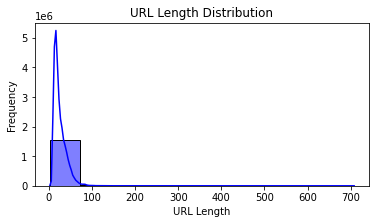

In [50]:

plt.figure(figsize=(6,3))
sns.histplot(df['url_length'],bins=10,kde=True,color='blue')
plt.title("URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

In [52]:
# test_samples_per_class = 1000
# test_dfs = []

# for category in df["category"].unique():
#     test_dfs.append(df[df["category"] == category].sample(test_samples_per_class, random_state=42))

# test_data = pd.concat(test_dfs)

In [54]:
# # Remove test data from training set
# train_data = df.drop(test_data.index)

# X_train = train_data.drop(columns=['category'])
# y_train = train_data['category']
# X_test = test_data.drop(columns=['category'])
# y_test = test_data['category']

### Train test split

In [96]:
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [82]:
# Custom Tokenizer with SnowballStemmer
stemmer = SnowballStemmer("english")
def stemmed_tokenizer(text):
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # Remove special characters
    tokens = text.split()
    return [stemmer.stem(token) for token in tokens]  # Apply stemming

In [86]:
X = df['website_url']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [88]:
text_pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", ngram_range=(1, 2), tokenizer=stemmed_tokenizer)),  # Use 1-2 grams
    ('tfidf', TfidfTransformer())
])

In [ ]:
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'website_url'),
])

In [100]:
X_train_transformed = preprocessor.fit_transform(X_train[['website_url']])

C:\Users\victus123\anaconda3\envs\ml_env\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# Balancing the data
smote=SMOTE(random_state=42)
X_train_balanced,Y_train_balanced=smote.fit_resample(X_train_transformed,y_train)

In [ ]:
pipeline = Pipeline([
    ('clf', XGBClassifier(objective="multi:softmax", num_class=len(Y_train_balanced.unique()), eval_metric="mlogloss"))
])

### Model evalution

In [70]:
# ✅ Training the Model
pipeline.fit(X_train_balanced, Y_train_balanced)

C:\Users\victus123\anaconda3\envs\ml_env\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\victus123\anaconda

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vect',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english',
                                                                                   tokenizer=<function stemmed_tokenizer at 0x0000027700312158>)),
                                                                  ('tfidf',
                                                                   TfidfTransformer())]),
                                                  'website_url'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                     

In [72]:
# ✅ Making Predictions
X_test_transformed=preprocessor.transform(X_test)
y_pred = pipeline.predict(X_test_transformed)

In [74]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [76]:
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))



✅ Accuracy: 0.31153333333333333

📊 Classification Report:
               precision    recall  f1-score   support

       Adult       0.21      0.58      0.31      1000
        Arts       0.65      0.25      0.36      1000
    Business       0.19      0.23      0.21      1000
   Computers       0.42      0.20      0.27      1000
       Games       0.40      0.49      0.44      1000
      Health       0.22      0.31      0.26      1000
        Home       0.90      0.40      0.55      1000
        Kids       0.17      0.37      0.24      1000
        News       0.37      0.20      0.26      1000
  Recreation       0.25      0.15      0.19      1000
   Reference       0.46      0.60      0.52      1000
     Science       0.26      0.38      0.31      1000
    Shopping       0.19      0.08      0.11      1000
     Society       0.43      0.17      0.24      1000
      Sports       0.81      0.28      0.41      1000

    accuracy                           0.31     15000
   macro avg       0

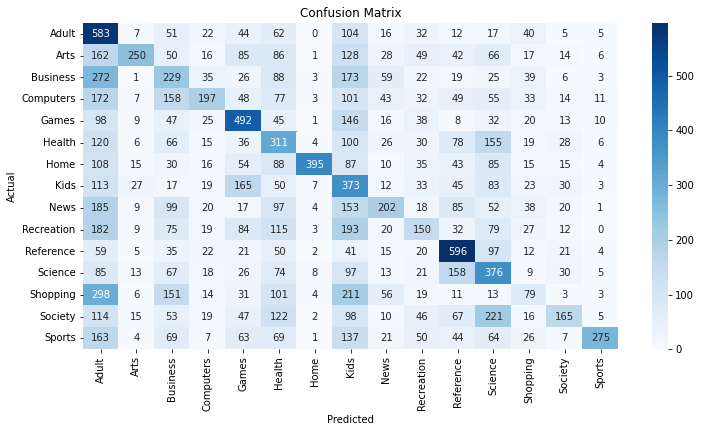

In [78]:
plt.figure(figsize=(12,6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# 🔹 **Test New URLs**
new_urls = [
    "https://www.espn.com/nba/scores",
    "http://netflix.com/show/98765",
    "https://github.com/tensorflow/models",
    "https://www.bbc.com/news/politics",
    "renewable-resources.netlify.app"
]

new_urls_processed = [preprocess_url(url) for url in new_urls]
predictions = pipeline.predict(pd.DataFrame({"website_url": new_urls_processed, "query_count": [0]*len(new_urls), "url_length": [len(url) for url in new_urls], "num_count": [sum(c.isdigit() for c in url) for url in new_urls]}))

print("\n🔹 Predictions on New URLs:")
for url, category in zip(new_urls, predictions):
    print(f"{url} → {category}")

In [ ]:
test_data['category'].value_counts()

In [ ]:
df['category'].value_counts()

In [ ]:
df.columns

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

In [1]:
import tensorflow as tf

def check_gpu():
    """Checks for GPU availability and prints relevant information."""

    print("TensorFlow Version:", tf.__version__)

    # Method 1: Check for physical devices (Recommended for TF 2.x and later)
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available (Physical): ", len(physical_devices))
    if physical_devices:
        for gpu in physical_devices:
            print("  GPU:", gpu)
    else:
        print("  No GPUs found (Physical).")

    # Method 2: Check for logical devices (Can show virtual GPUs, less reliable)
    logical_devices = tf.config.list_logical_devices('GPU')
    print("Num GPUs Available (Logical): ", len(logical_devices))
    if logical_devices:
        for gpu in logical_devices:
            print("  GPU:", gpu)
    else:
        print("  No GPUs found (Logical).")


    try:
        # Attempt a simple GPU computation
        with tf.device('/GPU:0'):  # Try placing a tensor on the first GPU
            a = tf.constant([1, 2, 3])
            print("Tensor created on GPU:", a)
            print("GPU is working.")
    except RuntimeError as e:
        print("Error during GPU computation:", e)
        print("GPU might not be configured correctly.")

    # Additional Check: Check if TensorFlow was built with CUDA
    print("TensorFlow built with CUDA:", tf.test.is_built_with_cuda())


if __name__ == "__main__":
    check_gpu()

TensorFlow Version: 2.1.0
Num GPUs Available (Physical):  1
  GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Num GPUs Available (Logical):  1
  GPU: LogicalDevice(name='/device:GPU:0', device_type='GPU')
Tensor created on GPU: tf.Tensor([1 2 3], shape=(3,), dtype=int32)
GPU is working.
TensorFlow built with CUDA: True


In [ ]:
pip uninstall tensorflow

In [ ]:
pip install tensorflow-gpu==2.18.0

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [5]:
for device in tf.config.experimental.list_logical_devices():
    print(device)


LogicalDevice(name='/device:CPU:0', device_type='CPU')
LogicalDevice(name='/device:GPU:0', device_type='GPU')


In [7]:
!nvidia-smi

Wed Feb 26 16:40:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              3W /   30W |    3259MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:

import time

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available!")
else:
    print("❌ GPU not found. Running on CPU.")

# Function to measure execution time
def benchmark_tensor_operation(device):
    shape = (1000, 1000)  # Large matrix size for performance test
    a = tf.random.normal(shape)
    b = tf.random.normal(shape)

    # Run operation on specified device
    with tf.device(device):
        start_time = time.time()
        for _ in range(100):  # Run multiple times for better measurement
            c = tf.matmul(a, b)
        end_time = time.time()

    return end_time - start_time

# Benchmark CPU
cpu_time = benchmark_tensor_operation('/CPU:0')
print(f"⏳ CPU Time: {cpu_time:.4f} seconds")

# Benchmark GPU (if available)
if tf.config.list_physical_devices('GPU'):
    gpu_time = benchmark_tensor_operation('/GPU:0')
    print(f"⚡ GPU Time: {gpu_time:.4f} seconds")
    print(f"🚀 Speedup: {cpu_time / gpu_time:.2f}x faster on GPU")
else:
    print("⚠ Running only on CPU, no GPU detected.")


✅ GPU is available!
⏳ CPU Time: 1.8941 seconds
⚡ GPU Time: 0.0157 seconds
🚀 Speedup: 120.88x faster on GPU
